In [0]:
import mido
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import colorConverter
from matplotlib import colors
import matplotlib.patches as mpatches


In [53]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/multipitch_estimation')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# inherit the origin mido class
class MidiFile(mido.MidiFile):

    def __init__(self, filename):

        mido.MidiFile.__init__(self, filename)
        self.sr = 10
        self.meta = {}
        self.events = self.get_events()

    def get_events(self):
        mid = self
#         print(mid)

        # There is > 16 channel in midi.tracks. However there is only 16 channel related to "music" events.
        # We store music events of 16 channel in the list "events" with form [[ch1],[ch2]....[ch16]]
        # Lyrics and meta data used a extra channel which is not include in "events"

        events = [[] for x in range(16)]

        # Iterate all event in the midi and extract to 16 channel form
        for track in mid.tracks:
            for msg in track:
                try:
                    channel = msg.channel
                    events[channel].append(msg)
                except AttributeError:
                    try:
                        if type(msg) != type(mido.UnknownMetaMessage):
                            self.meta[msg.type] = msg.dict()
                        else:
                            pass
                    except:
                        print("error",type(msg))

        return events

    def get_roll(self):
        events = self.get_events()
        # Identify events, then translate to piano roll
        # choose a sample ratio(sr) to down-sample through time axis
        sr = self.sr

        # compute total length in tick unit
        length = self.get_total_ticks()

        # allocate memory to numpy array
        roll = np.zeros((16, 128, length // sr), dtype="int8")

        # use a register array to save the state(no/off) for each key
        note_register = [int(-1) for x in range(128)]

        # use a register array to save the state(program_change) for each channel
        timbre_register = [1 for x in range(16)]


        for idx, channel in enumerate(events):

            time_counter = 0
            volume = 100
            # Volume would change by control change event (cc) cc7 & cc11
            # Volume 0-100 is mapped to 0-127

#             print("channel", idx, "start")
            for msg in channel:
                if msg.type == "control_change":
                    if msg.control == 7:
                        volume = msg.value
                        # directly assign volume
                    if msg.control == 11:
                        volume = volume * msg.value // 127
                        # change volume by percentage
                    # print("cc", msg.control, msg.value, "duration", msg.time)

                if msg.type == "program_change":
                    timbre_register[idx] = msg.program
#                     print("channel", idx, "pc", msg.program, "time", time_counter, "duration", msg.time)



                if msg.type == "note_on":
#                     print("on ", msg.note, "time", time_counter, "duration", msg.time, "velocity", msg.velocity)
                    note_on_start_time = time_counter // sr
                    note_on_end_time = (time_counter + msg.time) // sr
                    intensity = volume * msg.velocity // 127



					# When a note_on event *ends* the note start to be play 
					# Record end time of note_on event if there is no value in register
					# When note_off event happens, we fill in the color
                    if note_register[msg.note] == -1:
                        note_register[msg.note] = (note_on_end_time,intensity)
                    else:
					# When note_on event happens again, we also fill in the color
                        old_end_time = note_register[msg.note][0]
                        old_intensity = note_register[msg.note][1]
                        roll[idx, msg.note, old_end_time: note_on_end_time] = old_intensity
                        note_register[msg.note] = (note_on_end_time,intensity)


                if msg.type == "note_off":
#                     print("off", msg.note, "time", time_counter, "duration", msg.time, "velocity", msg.velocity)
                    note_off_start_time = time_counter // sr
                    note_off_end_time = (time_counter + msg.time) // sr
                    note_on_end_time = note_register[msg.note][0]
                    intensity = note_register[msg.note][1]
					# fill in color
                    roll[idx, msg.note, note_on_end_time:note_off_end_time] = intensity

                    note_register[msg.note] = -1  # reinitialize register

                time_counter += msg.time

                # TODO : velocity -> done, but not verified
                # TODO: Pitch wheel
                # TODO: Channel - > Program Changed / Timbre catagory
                # TODO: real time scale of roll

            # if there is a note not closed at the end of a channel, close it
            for key, data in enumerate(note_register):
                if data != -1:
                    note_on_end_time = data[0]
                    intensity = data[1]
                    # print(key, note_on_end_time)
                    note_off_start_time = time_counter // sr
                    roll[idx, key, note_on_end_time:] = intensity
                note_register[idx] = -1

        return roll

    def get_roll_image(self):
        
        roll = self.get_roll()
        plt.ioff()

        K = 16

        transparent = colorConverter.to_rgba('black')
        colors = [mpl.colors.to_rgba(mpl.colors.hsv_to_rgb((i / K, 1, 1)), alpha=1) for i in range(K)]
        cmaps = [mpl.colors.LinearSegmentedColormap.from_list('my_cmap', [transparent, colors[i]], 128) for i in
                 range(K)]

        for i in range(K):
            cmaps[i]._init()  # create the _lut array, with rgba values
            # create your alpha array and fill the colormap with them.
            # here it is progressive, but you can create whathever you want
            alphas = np.linspace(0, 1, cmaps[i].N + 3)
            cmaps[i]._lut[:, -1] = alphas

        fig = plt.figure(figsize=(4, 3))
        a1 = fig.add_subplot(111)
        a1.axis("equal")
        a1.set_facecolor("white")

        array = []

        for i in range(K):
            try:
                img = a1.imshow(roll[i], interpolation='nearest', cmap=cmaps[i], aspect='auto')
                array.append(img.get_array())
            except IndexError:
                pass
        return array

    def draw_roll(self):

        max_length = 300000
        roll = self.get_roll()

        # build and set fig obj
        plt.ioff()
        fig = plt.figure(figsize=(15, 10))
        a1 = fig.add_subplot(111)
#         a1.axis("equal")
        a1.set_facecolor("white")

        # change unit of time axis from tick to second
        tick = self.get_total_ticks()
        second = mido.tick2second(tick, self.ticks_per_beat, self.get_tempo())
#         print(second)
        if second > 10:
            x_label_period_sec = second // 10
        else:
            x_label_period_sec = second / 10  # ms
#         print(x_label_period_sec)
        x_label_interval = mido.second2tick(x_label_period_sec, self.ticks_per_beat, self.get_tempo()) / self.sr
#         print(x_label_interval)
        plt.xticks([int(x * x_label_interval) for x in range(20)], [round(x * x_label_period_sec, 2) for x in range(20)])

        # change scale and label of y axis
        plt.yticks([y*16 for y in range(8)], [y*16 for y in range(8)])
        a1.set_ylim(20, 88)

        cmap = colors.ListedColormap(['white', 'red'])
        a1.imshow(roll[0, :, 0 : max_length], origin="lower", interpolation='nearest', aspect='auto', cmap=cmap)
        
        plt.ion()
        plt.show()

    def get_tempo(self):
        try:
            return self.meta["set_tempo"]["tempo"]
        except:
            return 500000

    def get_total_ticks(self):
        max_ticks = 0
        for channel in range(16):
            ticks = sum(msg.time for msg in self.events[channel])
            if ticks > max_ticks:
                max_ticks = ticks
        return max_ticks



In [0]:
def draw_piano_roll(mid_true_path, mid_result_path):

    mid_result = MidiFile(mid_result_path)
    mid_true = MidiFile(mid_true_path)
    
    max_length = 200000
    roll_result = mid_result.get_roll()
    roll_true = mid_true.get_roll()
    roll_result = roll_result[0, :, 0 : max_length]
    roll_true = roll_true[0, :, 0 : max_length]
    
    # build and set fig obj
#     plt.ioff()

    fig = plt.figure(figsize=(15, 15))

    a1 = fig.add_subplot(111)
    a1.set_axisbelow(True)
    plt.rcParams["axes.axisbelow"] = True
    #         a1.axis("equal")
#     a1.set_facecolor("black")

    # change unit of time axis from tick to second
    tick = mid_result.get_total_ticks()
    second = mido.tick2second(tick, mid_result.ticks_per_beat, mid_result.get_tempo())
    #         print(second)
    if second > 10:
        x_label_period_sec = second // 10
    else:
        x_label_period_sec = second / 10  # ms
    #         print(x_label_period_sec)
    x_label_interval = mido.second2tick(x_label_period_sec, mid_result.ticks_per_beat, mid_result.get_tempo()) / mid_result.sr
    #         print(x_label_interval)
    plt.xticks([int(x * x_label_interval) for x in range(20)], [round(x * x_label_period_sec, 2) for x in range(20)])

    # change scale and label of y axis
#     plt.yticks([y*16 for y in range(8)], [y*16 for y in range(8)])

    a1.set_ylim(20, 100)
    a1.set_yticks(np.arange(20, 100, 1))
#     for y in np.arange(20, 100, 1):
#         a1.axhline(y, color='#E8E8E8')


    # cmap = colors.ListedColormap(['white', 'red'])
    roll_true[roll_true > 0] = 1.0
    a1.imshow(roll_true, origin="lower", interpolation='none', aspect='auto', cmap=colors.ListedColormap(['white', 'blue']))

    # img_mask = np.ma.masked_array(roll_result > 0, roll_result)
    roll_result[roll_result > 0] = 1.0
    plt.imshow(roll_result, origin="lower", interpolation='none', aspect='auto', cmap=colors.ListedColormap(['white', 'orange']), alpha=0.7) # interpolation='none'
    plt.ylabel('Midi-номер ноты', fontsize=14)
    plt.xlabel('Время, с', fontsize=14)
    


    orange_patch = mpatches.Patch(color='orange', label='Предсказанный MIDI-файл')
    blue_patch = mpatches.Patch(color='#AFA0F5', label='Оригинальный MIDI-файл')


    plt.legend(handles=[orange_patch, blue_patch], fontsize=14)
#     plt.ion()
    plt.savefig('/content/gdrive/My Drive/multipitch_estimation/' + os.path.splitext(mid_result_path)[0] + '.png', bbox_inches='tight')
    plt.show()

    

In [0]:

# mid_result_path = 'midi_converted_from_wav/MAPS_MUS-bk_xmas1_ENSTDkCl_thrshld_0.5.mid'
# mid_true_path = 'ENSTDkCl/MUS/MAPS_MUS-bk_xmas1_ENSTDkCl.mid'

# mid_result_path = 'midi_converted_from_wav/MAPS_MUS-scn15_12_ENSTDkCl_thrshld_0.5.mid'
# mid_true_path = 'ENSTDkCl/MUS/MAPS_MUS-scn15_12_ENSTDkCl.mid'


# mid_result_path = 'midi_converted_from_wav/MAPS_ISOL_CH0.3_F_ENSTDkCl_thrshld_0.9.mid'
# mid_true_path = 'ENSTDkCl/ISOL/CH/MAPS_ISOL_CH0.3_F_ENSTDkCl.mid'

# mid_result_path = 'midi_converted_from_wav/MAPS_MUS-mz_570_1_ENSTDkCl_thrshld_0.5.mid'
# mid_true_path = 'ENSTDkCl/MUS/MAPS_MUS-mz_570_1_ENSTDkCl.mid'

# mid_result_path = 'midi_converted_from_wav/moonlight_thrshld_0.3.mid'
# mid_true_path = 'moonlight.mid'

mid_result_path = 'midi_converted_from_wav/for_elise_10_thrshld_0.75.mid'
mid_true_path = 'furelise.mid'

# mid_result_path = 'midi_converted_from_wav/MAPS_ISOL_TR2_F_S1_M52_ENSTDkCl_thrshld_0.9.mid'
# mid_true_path = 'ENSTDkCl/ISOL/TR2/MAPS_ISOL_TR2_F_S1_M52_ENSTDkCl.mid'

# mid_result_path = 'midi_converted_from_wav/MAPS_ISOL_TR2_F_S0_M47_ENSTDkCl_thrshld_0.9.mid'
# mid_true_path = 'ENSTDkCl/ISOL/TR2/MAPS_ISOL_TR2_F_S0_M47_ENSTDkCl.mid'

# mid_result_path = 'midi_converted_from_wav/MAPS_ISOL_RE_F_S0_M45_ENSTDkCl_thrshld_0.9.mid'
# mid_true_path = 'ENSTDkCl/ISOL/RE/MAPS_ISOL_RE_F_S0_M45_ENSTDkCl.mid'





# mid_result_path = 'midi_converted_from_wav/fur_elise_thrshld_0.8.mid'

# mid_result_path = 'midi_converted_from_wav/moonlight_thrshld_0.5.mid'

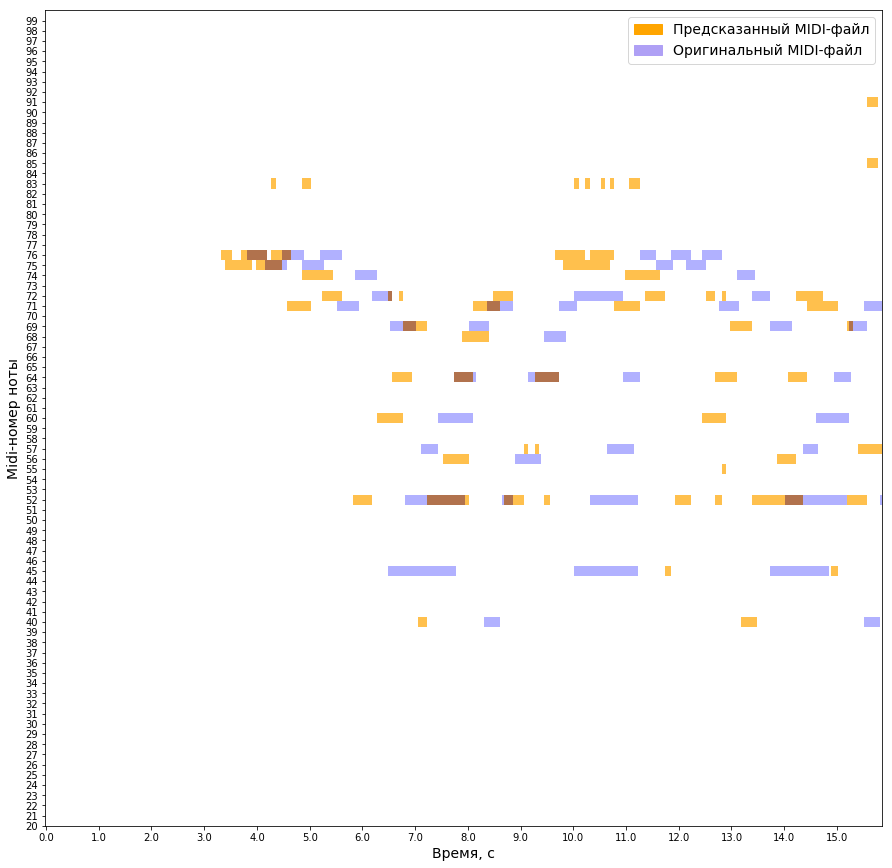

In [64]:
draw_piano_roll(mid_true_path, mid_result_path)

In [0]:

def draw_roll(mid_result_path):
    mid_result = MidiFile(mid_result_path)

    max_length = 1000
    roll_result = mid_result.get_roll()
    # roll_true = mid_true.get_roll()
    roll_result = roll_result[0, :, 0 : max_length]
    # roll_true = roll_true[0, :, 0 : max_length]
    # build and set fig obj
    plt.ioff()
    fig = plt.figure(figsize=(15, 10))
    a1 = fig.add_subplot(111)
    #         a1.axis("equal")
    a1.set_facecolor("white")

    # change unit of time axis from tick to second
    tick = mid_result.get_total_ticks()
    second = mido.tick2second(tick, mid_result.ticks_per_beat, mid_result.get_tempo())
    #         print(second)
    if second > 10:
        x_label_period_sec = second // 10
    else:
        x_label_period_sec = second / 10  # ms
    #         print(x_label_period_sec)
    x_label_interval = mido.second2tick(x_label_period_sec, mid_result.ticks_per_beat, mid_result.get_tempo()) / mid_result.sr
    #         print(x_label_interval)
    plt.xticks([int(x * x_label_interval) for x in range(20)], [round(x * x_label_period_sec, 2) for x in range(20)])

    # change scale and label of y axis
    plt.yticks([y*16 for y in range(8)], [y*16 for y in range(8)])
    a1.set_ylim(20, 100)

    # cmap = colors.ListedColormap(['white', 'red'])
    # roll_true[roll_true > 0] = 1.0
    # a1.imshow(roll_true, origin="lower", interpolation='none', aspect='auto', cmap=colors.ListedColormap(['white', 'blue']))

    # img_mask = np.ma.masked_array(roll_result > 0, roll_result)
    roll_result[roll_result > 0] = 1.0
    
#     for i in np.arange(roll_result.shape[0]):
        
#         plt.imshow(roll_result[i], origin="lower", interpolation='none', aspect='auto', cmap=colors.ListedColormap(['white', 'orange']), alpha=0.7) # interpolation='none'
    plt.imshow(roll_result, origin="lower", interpolation='none', aspect='auto', cmap=colors.ListedColormap(['white', 'orange']), alpha=0.7) # interpolation='none'

    plt.ylabel('Midi-номер ноты')
    plt.xlabel('Время, с')


    orange_patch = mpatches.Patch(color='orange', label='Предсказанный MIDI-файл')
    blue_patch = mpatches.Patch(color='#AFA0F5', label='Оригинальный MIDI-файл')


    plt.legend(handles=[orange_patch, blue_patch])

    plt.ion()
    plt.show()

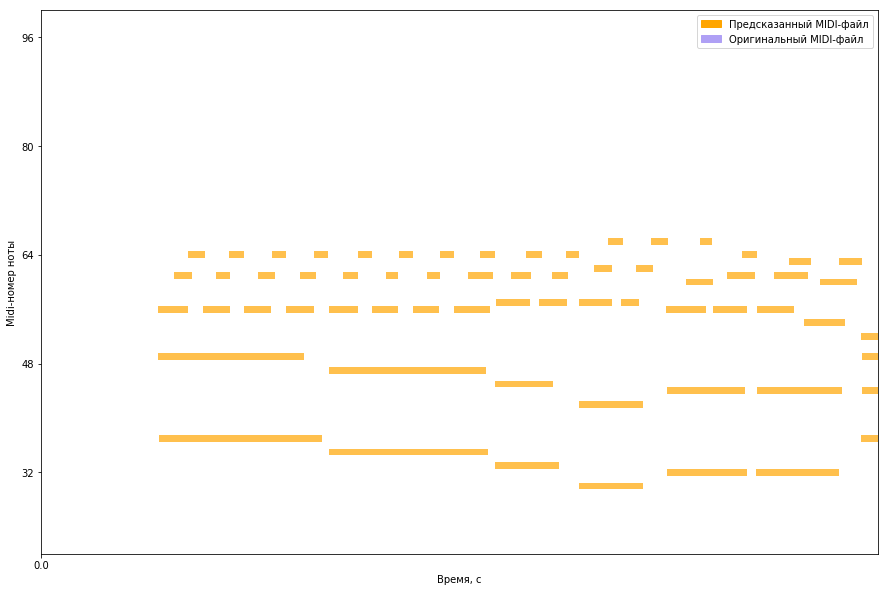

In [41]:
draw_roll('moonlight.mid')

In [40]:
! ls

 base_model.ipynb
 config.py
 ENSTDkCl
 experiment_metrics_history_2019-05-10_23:25.npy
 experiment_metrics_history_2019-05-22_13:54.npy
 experiment_metrics_history_2019-05-23_11:34.npy
 experiment_metrics_history_2019-05-28_12:58.npy
 experiment_metrics_history_2019-05-30_17:13.npy
 experiment_metrics_history_2019-05-30_19:26.npy
 experiment_metrics_history_2019-06-15_12:55.npy
 experiment_metrics_history_2019-06-16_10:40.npy
 experiment_metrics_history_2019-06-18_11:41.npy
 experiment_parameters_history_2019-05-10_23:25.npy
 experiments_with_fourier
 files_test_names.npy
 files_train_names.npy
 furelise.mid
 furelise.wav
 MAPS_data_preparing.ipynb
 midi_converted_from_wav
 MIDI_plots.ipynb
 midi_statistics.npy
'moonlight (1).mid'
 moonlight.wav
 mueller_m_fundamentals_of_music_processing_audio_analysis_al.pdf
 multipitch_estimation_colab_learned_filterbanks.ipynb
 multipitch_estimation_colab_stft_cos_window.ipynb
 multipitch_estimation_colab_stft.ipynb
 multipitch_estimation_colab_tr